# Modelo 'Prophet' para multiples series temporales
En este documento se muestra el proceso para crear y entrenar el modelo de machine learning para hacer predicciones de las lecturas de los sensores. La obtencion de dichas lecturas se muestra en el archivo "eda.ipynb".

Se resuelve el problema de regresion para series de tiempo (Time Series) multiples, es decir, se debe estimar el valor de una variable continua para multiples series temporales. Se implementara el modelo 'Prophet'.

## Preprocesamiento de los datos

El preprocesamiento de los datos consiste en:

1. Llenar valores ausentes y eliminar duplicados
2. Eliminar outliers y multicolinealidad
3. Convertir variables categoricas en numericas
4. Estandarizar (escalar) los datos

Para series temporales no aplica escalar los datos, por otro lado, se implementara el modelo 'Prophet', el cual maneja bien los outliers y valores ausentes, por lo tanto, no es necesario eliminarlos por ahora.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from prophet import Prophet
import os
from sklearn.metrics import mean_absolute_error
import numpy as np

In [3]:
# Read DataFrame
df = pd.read_csv('../data/processed/factLecturas_2025-09-24 11:41:38.csv', sep=',', header=0)

# Show DataFrame
df.head(3)

,ReadId,TimeSpan,SensorId,Value,LocalTimeSpan
0,05543cf3-ec51-4760-a9af-8efa01a203e6,2025-01-18 13:48:44.190,063276ed-657e-40a2-a17b-0c685af518f6,31.20,2025-01-18 07:48:44.190
1,a3c80788-c698-41cc-835f-aedd98adb72c,2025-01-18 13:48:44.195,22f8b472-4022-41a9-b7b7-37e83a532df0,35.55,2025-01-18 07:48:44.195
2,4e223d79-4791-4c2a-9d88-97c8efa170bc,2025-01-18 13:48:44.199,267e3d44-9b7f-460c-b34b-603fe0fa9972,36.90,2025-01-18 07:48:44.199


In [4]:
# Change date column to datetime
df['TimeSpan'] = pd.to_datetime(df['TimeSpan'])
df['LocalTimeSpan'] = pd.to_datetime(df['TimeSpan'])

# DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165411 entries, 0 to 165410
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ReadId         165411 non-null  object        
 1   TimeSpan       165411 non-null  datetime64[ns]
 2   SensorId       165411 non-null  object        
 3   Value          165411 non-null  float64       
 4   LocalTimeSpan  165411 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 6.3+ MB


### Eliminar duplicados

In [5]:
# Delete all row duplicates
df = df.drop_duplicates(subset=['ReadId'])

# Count duplicates
df.duplicated(subset=['ReadId']).sum()

0

### Multicolinealidad

Parece que las columnas 'TimeSpan' y 'LocalTimeSpan' solo varian por unas horas, es decir, es la misma informacion.

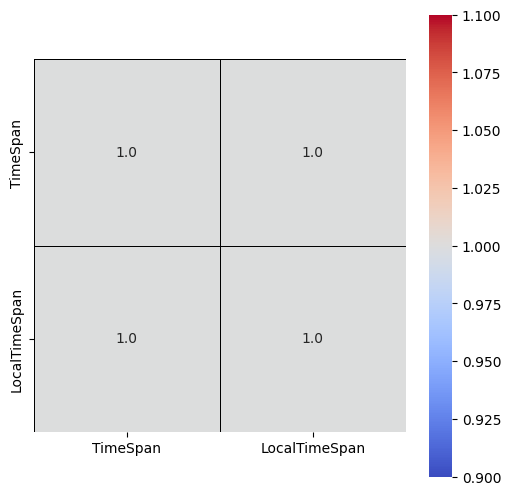

In [ ]:
df_split = df[['TimeSpan','LocalTimeSpan']]

# Heatmap
plt.figure(figsize = (5,5))
sns.heatmap(df_split.corr(), annot=True, square=True, cmap='coolwarm',
            fmt='.1f',annot_kws={"size": 10}, linewidths=0.5, linecolor='black')
plt.show()

Efectivamente, las columnas 'TimeSpan' y 'LocalTimeSpan' contienen la misma informacion, por lo tanto, se ignorara la columna 'LocalTimeSpan'.

In [6]:
# Extract columns
df = df[['ReadId', 'TimeSpan', 'SensorId', 'Value']]

### Convertir variables categoricas en numericas
La unica variable categorica es 'ReadId', pero no es relevante para el modelo de prediccion de valores medidos por el sensor, por lo tanto, la columna 'ReadId' tambien sera ignorada.


In [7]:
# Extract columns
df = df[['TimeSpan', 'SensorId', 'Value']]

# DataFrame columns
print(df.columns)

Index(['TimeSpan', 'SensorId', 'Value'], dtype='object')


## Planteamiento del problema
Se tiene un total de 165,407 mediciones de 40 sensores diferentes.

In [8]:
# DataFrame shape
print(df.shape)

(165407, 3)


In [9]:
# Count unique values
print(df['SensorId'].nunique())

40


Para realizar el análisis de series temporales para los 40 sensores diferentes, las series de tiempo se trataran por separado. Se usara el modelo 'Prophet' para predecir los datos secuenciales a lo largo del tiempo (forecasting de series de tiempo).

## "Prophet" Model

In [10]:
# Set variables
FUTURE_DAYS = 6
RESAMPLE_FREQ = 'H'

# Convert to compatible format for Prophet (ds, y)
df = df.rename(columns={'TimeSpan': 'ds', 'Value': 'y'})
df = df.sort_values(by='ds',ascending=True)

# Resample by hour and obtain the mean of data
df_resampled = df.set_index('ds').groupby('SensorId')['y'].resample(RESAMPLE_FREQ).mean().reset_index()
df_resampled.head(5)

,SensorId,ds,y
0,063276ed-657e-40a2-a17b-0c685af518f6,2025-01-08 21:00:00,41.025
1,063276ed-657e-40a2-a17b-0c685af518f6,2025-01-08 22:00:00,NaN
2,063276ed-657e-40a2-a17b-0c685af518f6,2025-01-08 23:00:00,NaN
3,063276ed-657e-40a2-a17b-0c685af518f6,2025-01-09 00:00:00,NaN
4,063276ed-657e-40a2-a17b-0c685af518f6,2025-01-09 01:00:00,NaN


In [11]:
# Create directory to save the results
output_dir = '../data/processed/prophet_forecasts'
os.makedirs(output_dir, exist_ok=True)

# Obtain all sensors as a list
sensor_ids = df_resampled['SensorId'].unique()
print(f"Total different sensors: {len(sensor_ids)}")

Total different sensors: 40


In [12]:
# Dictionary to save the resulting DataFrames
results = {}

for sensor_id in sensor_ids:
    df_sensor = df_resampled[df_resampled['SensorId'] == sensor_id].copy()
    df_sensor = df_sensor.dropna(subset=['y'])
    
    if len(df_sensor) < 2:
        print(f" ❌ Insufficient data for sensor {sensor_id}. Skipping.")
        continue

    # Create model. Weekly and daily seasonality is automatically activated
    # if sufficient data is detected
    model = Prophet(
        yearly_seasonality='auto', 
        weekly_seasonality='auto', 
        daily_seasonality='auto',
        # changepoint_prior_scale=0.03 
    )
    
    # Fit the model
    try:
        model.fit(df_sensor)
    except Exception as e:
        print(f" ❌ Error training the model for {sensor_id}: {e}. Skipping.")
        continue

    # Make forecast
    future = model.make_future_dataframe(periods=FUTURE_DAYS * 24, freq=RESAMPLE_FREQ)
    forecast = model.predict(future)
    
    # Add column 'y' to DataFrame forecast
    actual_values = df_sensor[['ds', 'y']]
    forecast = pd.merge(forecast, actual_values, on='ds', how='left')
    
    # Store the forecast
    results[sensor_id] = forecast
    
    # Visualization
    fig = model.plot(forecast)
    plt.title(f"Time Series forecast for sensor: {sensor_id}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    
    # Save plot
    fig.savefig(os.path.join(output_dir, f'forecast_{sensor_id}.png'))
    plt.close(fig)

print("\n✅ Process completed.")
print(f"The forecast charts have been saved to the directory '{output_dir}'.")
print("The results of the predictions are in the 'results' dictionary.")

17:55:01 - cmdstanpy - INFO - Chain [1] start processing
17:55:02 - cmdstanpy - INFO - Chain [1] done processing
17:55:04 - cmdstanpy - INFO - Chain [1] start processing
17:55:04 - cmdstanpy - INFO - Chain [1] done processing
17:55:04 - cmdstanpy - INFO - Chain [1] start processing
17:55:04 - cmdstanpy - INFO - Chain [1] done processing
17:55:05 - cmdstanpy - INFO - Chain [1] start processing
17:55:05 - cmdstanpy - INFO - Chain [1] done processing
17:55:06 - cmdstanpy - INFO - Chain [1] start processing
17:55:06 - cmdstanpy - INFO - Chain [1] done processing
17:55:06 - cmdstanpy - INFO - Chain [1] start processing
17:55:06 - cmdstanpy - INFO - Chain [1] done processing
17:55:07 - cmdstanpy - INFO - Chain [1] start processing
17:55:07 - cmdstanpy - INFO - Chain [1] done processing
17:55:07 - cmdstanpy - INFO - Chain [1] start processing
17:55:07 - cmdstanpy - INFO - Chain [1] done processing
17:55:08 - cmdstanpy - INFO - Chain [1] start processing
17:55:08 - cmdstanpy - INFO - Chain [1]

 ❌ Insufficient data for sensor decbab18-47d6-47f2-a8ec-37068abb0034. Skipping.


17:55:18 - cmdstanpy - INFO - Chain [1] start processing
17:55:18 - cmdstanpy - INFO - Chain [1] done processing
17:55:19 - cmdstanpy - INFO - Chain [1] start processing
17:55:19 - cmdstanpy - INFO - Chain [1] done processing
17:55:20 - cmdstanpy - INFO - Chain [1] start processing
17:55:20 - cmdstanpy - INFO - Chain [1] done processing
17:55:20 - cmdstanpy - INFO - Chain [1] start processing
17:55:21 - cmdstanpy - INFO - Chain [1] done processing
17:55:21 - cmdstanpy - INFO - Chain [1] start processing
17:55:21 - cmdstanpy - INFO - Chain [1] done processing
17:55:21 - cmdstanpy - INFO - Chain [1] start processing
17:55:21 - cmdstanpy - INFO - Chain [1] done processing



✅ Process completed.
The forecast charts have been saved to the directory '../data/processed/prophet_forecasts'.
The results of the predictions are in the 'results' dictionary.


Para medir la efectivadad de los modelos que usara la metrica error absoluto promedio (MAE).

In [ ]:
# Calculate MAE forr every model
mae_scores = {}
all_maes = []

for sensor_id, forecast_df in results.items():
    historical_comparison = forecast_df.dropna(subset=['y'])
    
    if len(historical_comparison) == 0:
        print(f"There are not enough points to calculate the MAE for {sensor_id}.")
        mae_scores[sensor_id] = np.nan
        continue
        
    mae = mean_absolute_error(historical_comparison['y'], historical_comparison['yhat'])
    mae_scores[sensor_id] = mae
    all_maes.append(mae)    
    print(f"MAE for sensor {sensor_id}: {mae:.4f}")

MAE for sensor 063276ed-657e-40a2-a17b-0c685af518f6: 3.7534
MAE for sensor 0db793d3-03f9-4f57-9ff0-a09ea5a4d23a: 0.0000
MAE for sensor 0f6a552b-3f6a-48f1-b13a-2e7734cf957d: 0.2246
MAE for sensor 1620956c-77d6-469e-82f8-6272fd987503: 0.9306
MAE for sensor 1929d6d6-d2c8-4e2a-af69-2b6fb0cd590f: 0.0000
MAE for sensor 1e32d6ac-8740-4f45-bf58-6bce274fb637: 0.3042
MAE for sensor 22f8b472-4022-41a9-b7b7-37e83a532df0: 3.9145
MAE for sensor 25057233-49f7-474f-b924-909aa8ba4a04: 2.1392
MAE for sensor 267e3d44-9b7f-460c-b34b-603fe0fa9972: 3.5522
MAE for sensor 2db12284-062b-42b7-b540-142d07749e2d: 0.0621
MAE for sensor 315af56b-2340-4ae7-a4b6-ecd2ef002eef: 1.4140
MAE for sensor 3453da27-ac58-485f-99f5-3e3a7a4cc3dc: 0.9673
MAE for sensor 42d86407-9679-4224-86dd-5ec7b756d38d: 0.2578
MAE for sensor 467aeeec-e69a-42fa-8a07-d9c72f513e9d: 1.1297
MAE for sensor 485e3767-dba2-4280-8bb4-2f38f48f3993: 0.0000
MAE for sensor 5064c764-1fa5-49d8-9b8f-080d9eb38ab7: 0.9872
MAE for sensor 62dbc359-5b75-4de6-8bb3-f

**Nota:** Se observa que la mayoria de los errores absolutos medios son bajos (entre 0 y 1), pero hay pocos que son relativamente altos (3.5 aproximadamente). Los modelos correspondienes a esos errores deben ser entrenados con otros parametros mas especificos y asi se disminuiran tales errores.

### Analisis de los resultados
Cada elemento del diccionario 'results' es un DataFrame, donde la clave es 'SensorId' y el valor es el DataFrame correspondiente. Se analizara solo un resultado.

In [14]:
# Extract one DataFrame
df_063276ed = results['063276ed-657e-40a2-a17b-0c685af518f6']
df_063276ed.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
0,2025-01-08 21:00:00,32.442312,37.020546,49.134120,32.442312,32.442312,10.692078,10.692078,10.692078,9.206047,9.206047,9.206047,1.486031,1.486031,1.486031,0.0,0.0,0.0,43.134390,41.025
1,2025-01-09 18:00:00,32.683194,28.351992,40.907499,32.683194,32.683194,1.722313,1.722313,1.722313,1.505434,1.505434,1.505434,0.216879,0.216879,0.216879,0.0,0.0,0.0,34.405507,33.550


ds: La marca de tiempo.

yhat_lower / yhat_upper: Los límites inferior y superior del intervalo de incertidumbre (confianza).

yhat: El valor predicho (el pronóstico central).

y: El valor real. Esta columna contendra n valores nulos al final, correspondientes a las predicciones hechas, donde n <= FUTURE_DAYS*24-(posibles valores nulos agregados al hacer el 'resample' en el DataFrame original)

In [99]:
df_063276ed.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
528,2025-02-06 19:00:00,40.675792,38.952435,51.663678,40.668246,40.683523,4.948995,4.948995,4.948995,4.776776,4.776776,4.776776,0.172220,0.172220,0.172220,0.0,0.0,0.0,45.624787,NaN
529,2025-02-06 20:00:00,40.687818,42.417750,55.196814,40.680210,40.695635,8.062121,8.062121,8.062121,7.930023,7.930023,7.930023,0.132098,0.132098,0.132098,0.0,0.0,0.0,48.749939,NaN
530,2025-02-06 21:00:00,40.699845,43.962694,56.161685,40.692175,40.707747,9.302890,9.302890,9.302890,9.206047,9.206047,9.206047,0.096843,0.096843,0.096843,0.0,0.0,0.0,50.002735,NaN
531,2025-02-06 22:00:00,40.711871,43.467668,55.384324,40.704110,40.719866,8.557069,8.557069,8.557069,8.490327,8.490327,8.490327,0.066742,0.066742,0.066742,0.0,0.0,0.0,49.268940,NaN
532,2025-02-06 23:00:00,40.723897,41.889916,54.238984,40.716076,40.731992,7.277376,7.277376,7.277376,7.235339,7.235339,7.235339,0.042037,0.042037,0.042037,0.0,0.0,0.0,48.001274,NaN


El diccionario 'mae_scores' contiene los pares 'SensorId':mae (clave:valor). La lista 'all_maes' contiene solo los 'mae' correspondientes a los 40 modelos. Veamos un ejemplo.

In [15]:
print(f"MAE for sensor '063276ed-657e-40a2-a17b-0c685af518f6': {mae_scores['063276ed-657e-40a2-a17b-0c685af518f6']:.3f}")

MAE for sensor '063276ed-657e-40a2-a17b-0c685af518f6': 3.753


In [16]:
print(f"MAE for model 0: {all_maes[0]:.3f}")

MAE for model 0: 3.753


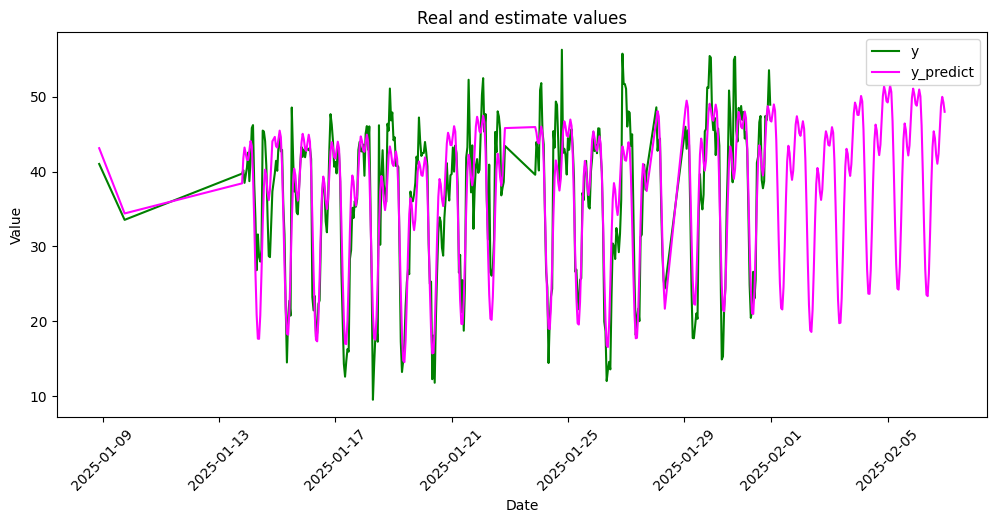

In [17]:
# Multiple Line plots
plt.figure(figsize = (12,5))
plt.plot(df_063276ed['ds'], df_063276ed['y'], color='green', linestyle='-')
plt.plot(df_063276ed['ds'], df_063276ed['yhat'], color='magenta')
plt.title('Real and estimate values')
plt.legend(['y','y_predict'])
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Value')
plt.show()

Las graficas correspondientes a los demas modelos se guardaron en: '../data/processed/prophet_forecasts'.